# Estimate current camera coverage and how many we want for better coverage

In [1]:
import os
from glob import glob
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Polygon, LineString

# import utility functions
import model_camera_coverage_utils as utils

inputs_folder = '/Users/rdcrlrka/Research/Soo_locks/inputs'
cam_positions_file = os.path.join(inputs_folder, 'cams.txt')
ortho_files = sorted(glob(os.path.join(inputs_folder, '..', 'outputs', 'soo_locks_photogrammetry_20251001171000', 'orthoimages', '*.tiff')))
refdem_file = os.path.join(inputs_folder, 'lidar_DSM_filled_cropped.tif')

output_folder = os.path.join(inputs_folder, '..', 'add_cameras')
os.makedirs(output_folder, exist_ok=True)

# Load camera positions
cams = pd.read_csv(cam_positions_file, sep=' ', header=0)
cams['channel'] = [x.split('_')[1] for x in cams['img_name']]


## Calculate current camera coverage

In [2]:
print('Creating polygon of model space')
model_space_gdf = utils.calculate_image_footprint(refdem_file)

print('Calculating image footprints')
gdf_list = []
for ortho_file in tqdm(ortho_files):
    gdf = utils.calculate_image_footprint(ortho_file)
    gdf_list += [gdf]
bounds_df = pd.concat(gdf_list).reset_index(drop=True)
bounds_gdf = gpd.GeoDataFrame(bounds_df, geometry=bounds_df['geometry'], crs=gdf.crs)

print('Calculating overlap areas')
overlap_gdf = utils.calculate_image_overlap(bounds_gdf)

print('Calculating area with no coverage')
no_coverage = utils.calculate_no_coverage(model_space_gdf, bounds_gdf)
print('Done')

Creating polygon of model space
Calculating image footprints


100%|██████████| 16/16 [00:36<00:00,  2.25s/it]


Calculating overlap areas
Calculating area with no coverage
Done


## Model the camera FOV

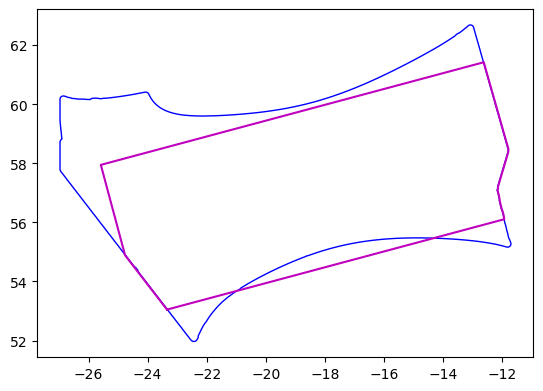

In [3]:
# Cropped slightly to where the image isn't super distorted
fov_h = 120
fov_v = 65

# Test for one camera to assess FOV values
bounds = bounds_gdf.loc[bounds_gdf['channel']=='ch16']
cam = cams.loc[cams['channel']=='ch16']
cam_poly = utils.create_new_footprint(
    cam[['X', 'Y', 'Z']].values[0],
    model_space=model_space_gdf
    )

fig, ax = plt.subplots()
ax.plot(cam_poly.exterior.coords.xy[0], cam_poly.exterior.coords.xy[1], '-m')
bounds.plot(ax=ax, facecolor='None', edgecolor='b')
plt.show()

## Model the ceiling trusses

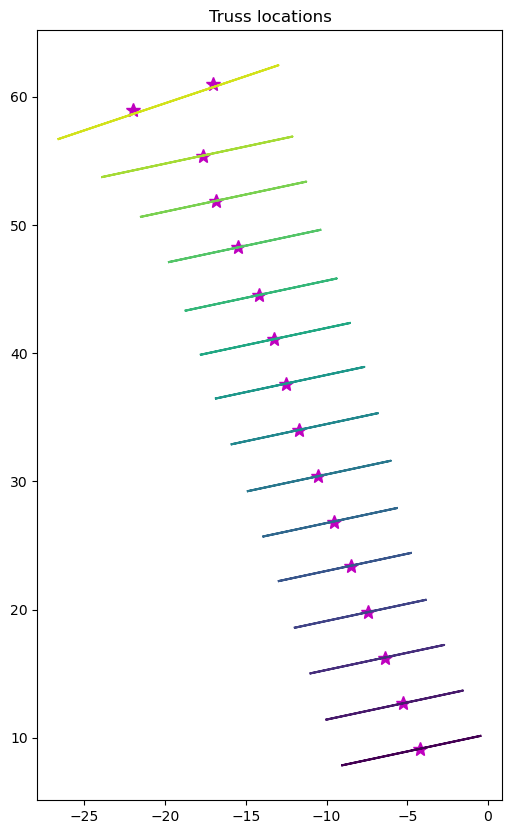

In [4]:
# Load the rafter heights from Dom
raster_heights_file = os.path.join(inputs_folder, 'rafter-heights(Rafter Z Values).csv')
rh = pd.read_csv(raster_heights_file)

# skip the northern trusses for now (not sure on the angles)
# truss_heights = rh.iloc[2:].reset_index(drop=True)
truss_heights = rh.copy()

# Get the center x and y coordinates from camera locations
x_coords, y_coords = [],[]
for i,row in truss_heights.iterrows():
    if i==0:
        x,y = -22, 59
    elif i==1:
        x,y = -17, 61
    else:
        ch1,ch2 = row['Label'].split('-')
        x,y = utils.get_coords_between_cams(ch1, ch2, cams)
    x_coords += [x]
    y_coords += [y]
truss_heights['xc'] = x_coords
truss_heights['yc'] = y_coords

fig, ax = plt.subplots(figsize=(6,10))

# Create LineString of bottom truss extent - extend 20 m perpendicular to camera yaw
truss_angle = 15
truss_ext = 20
extents = []
for i,row in truss_heights.iterrows():
    yleft = row['yc'] - (truss_ext * np.sin(np.deg2rad(truss_angle)))
    xleft = row['xc'] - (truss_ext * np.cos(np.deg2rad(truss_angle)))
    yright = row['yc'] + (truss_ext * np.sin(np.deg2rad(truss_angle)))
    xright = row['xc'] + (truss_ext * np.cos(np.deg2rad(truss_angle)))
    extent = LineString([(xleft,yleft), (xright, yright)])
    # crop to model space
    extent = extent.intersection(model_space_gdf['geometry'].values[0])
    extents += [extent]
    # plot
    ax.plot(row['xc'], row['yc'], '*m', markersize=10)

ax.set_title('Truss locations')

truss_heights['extent'] = extents

# Now, create 3D polygons by extending to the ceiling
ceiling_height = 10
geoms = []
for i,row in truss_heights.iterrows():
    x1, x2 = row['extent'].coords.xy[0]
    y1, y2 = row['extent'].coords.xy[1]
    z1 = row['Z-Value - 15cm']
    z2 = ceiling_height
    geoms += [Polygon([
        [x1, y1, z1],
        [x2, y2, z1],
        [x2, y2, z2],
        [x1, y1, z2],
        [x1, y1, z1]
    ])]

# Artificially modify the last two trusses to be one that crosses the last two cameras
# get current angle, dy/dx = tan(theta)
xmin, xmax = min(geoms[0].exterior.coords.xy[0]), max(geoms[0].exterior.coords.xy[0])
ymin, ymax = min(geoms[0].exterior.coords.xy[1]), max(geoms[0].exterior.coords.xy[1])
theta = np.rad2deg(np.tan((ymax-ymin) / (xmax-xmin)))
# get actual angle
ch15_coords = cams.loc[cams['channel']=='ch15', ['X', 'Y']].values[0]
ch16_coords = cams.loc[cams['channel']=='ch16', ['X', 'Y']].values[0]
target_theta = np.abs(np.rad2deg(np.tan(
    (ch15_coords[0] - ch16_coords[0]) 
    / (ch15_coords[1] - ch16_coords[1])
    )))
# get rotation angle
rot = theta - target_theta
geom_rotated = shapely.affinity.rotate(geoms[0], rot)
geoms = geoms[2:] + [geom_rotated]

# Convert to geodataframe
trusses_gdf = gpd.GeoDataFrame(geometry=geoms, crs="EPSG:32619")
for i,row in trusses_gdf.iterrows():
    ax.plot(row['geometry'].exterior.coords.xy[0], row['geometry'].exterior.coords.xy[1], 
            '-', color=plt.cm.viridis(i/len(trusses_gdf)))
plt.show()

## Plot current model coverage

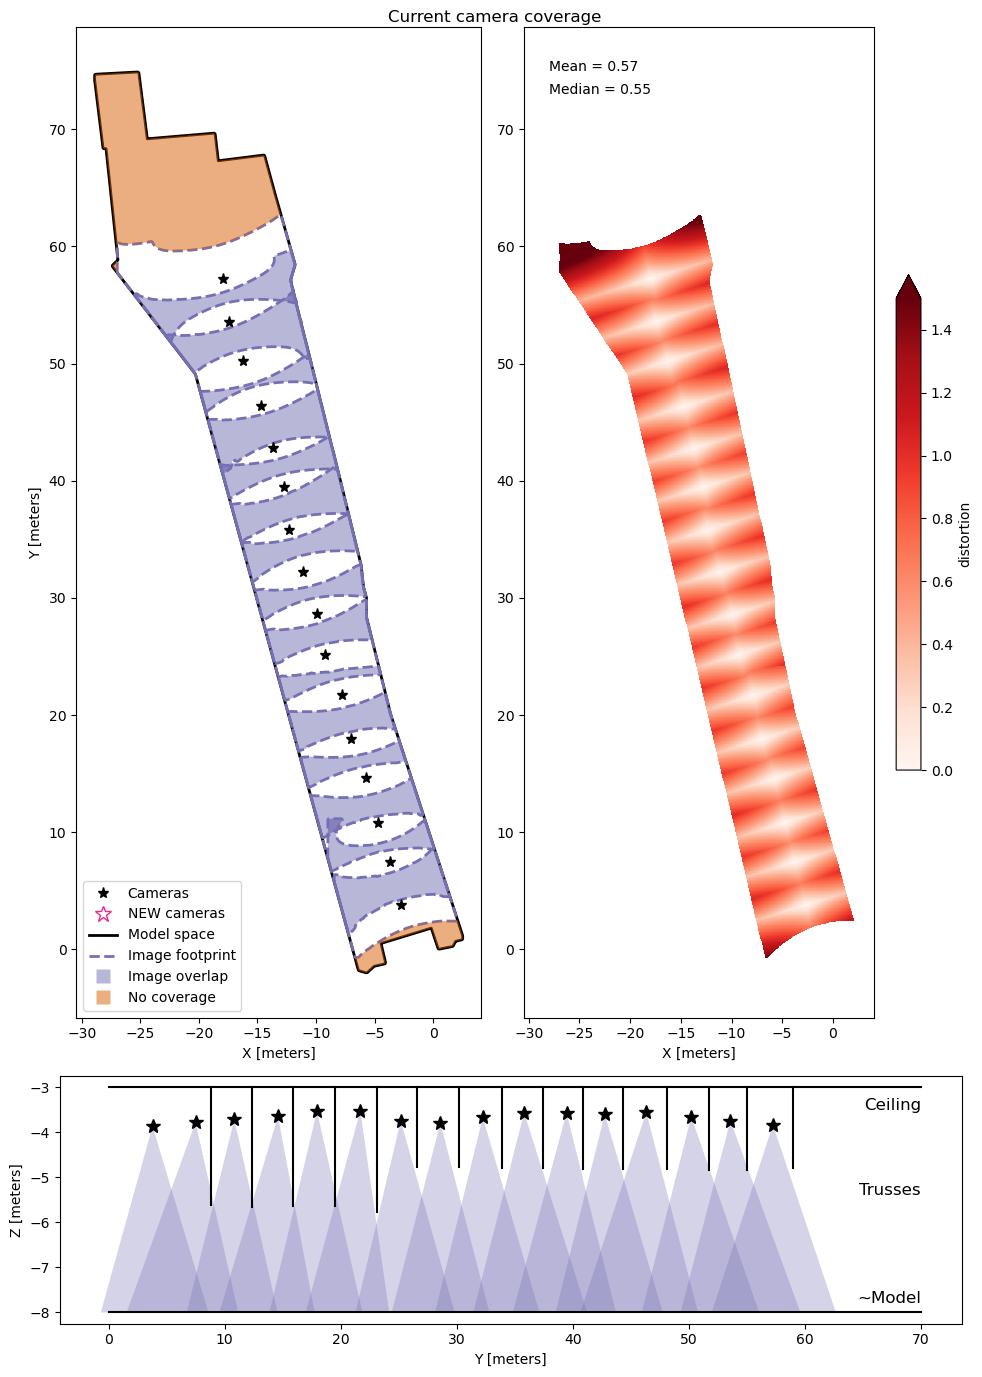

Figure saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/current_coverage.png
New camera specs saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/current_coverage_specs.csv


In [9]:
# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]
# plot model coverage
utils.plot_model_coverage(ax[0], model_space_gdf, bounds_gdf, overlap_gdf, cams, no_coverage)

# plot vertical view
utils.plot_vertical_view(ax[2], trusses_gdf, cams, cams_new=None, bounds = bounds_gdf, bounds_new = None)

# plot relative distortion
distortion_map = utils.create_distortion_map(
    cams_gdf = cams,
    footprints_gdf = bounds_gdf,
    yaw_series = 15 * np.ones(len(cams)),
    pitch_series = np.zeros(len(cams)),
    roll_series = np.zeros(len(cams)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf
)
# add the minimum value
distortion_map += 5.297444280721465
distortion_map.plot(ax=ax[1], cmap='Reds', vmin=0, vmax=1.5, cbar_kwargs={'shrink': 0.5})
# print distortion stats
ax[1].text(-28, 75, f"Mean = {np.round(distortion_map.mean().data, 2)}")
ax[1].text(-28, 73, f"Median = {np.round(distortion_map.median().data, 2)}")
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
ax[0].legend(loc='lower left')

fig.suptitle('Current camera coverage')
fig.tight_layout()
plt.show()

# Save figure
fig_file = os.path.join(output_folder, 'current_coverage.png')
fig.savefig(fig_file, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_file)

# Save new specs
out_file = os.path.join(output_folder, 'current_coverage_specs.csv')
utils.save_specs_los(bounds_gdf, cams_new=cams, cams=cams, out_file=out_file)

## Add 8 more NADIR cameras at truss height

/Users/rdcrlrka/.local/share/mamba/envs/soo_locks/lib/python3.12/site-packages/geopandas/array.py:1755: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 19N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


No coverage area =  125.6 m^2


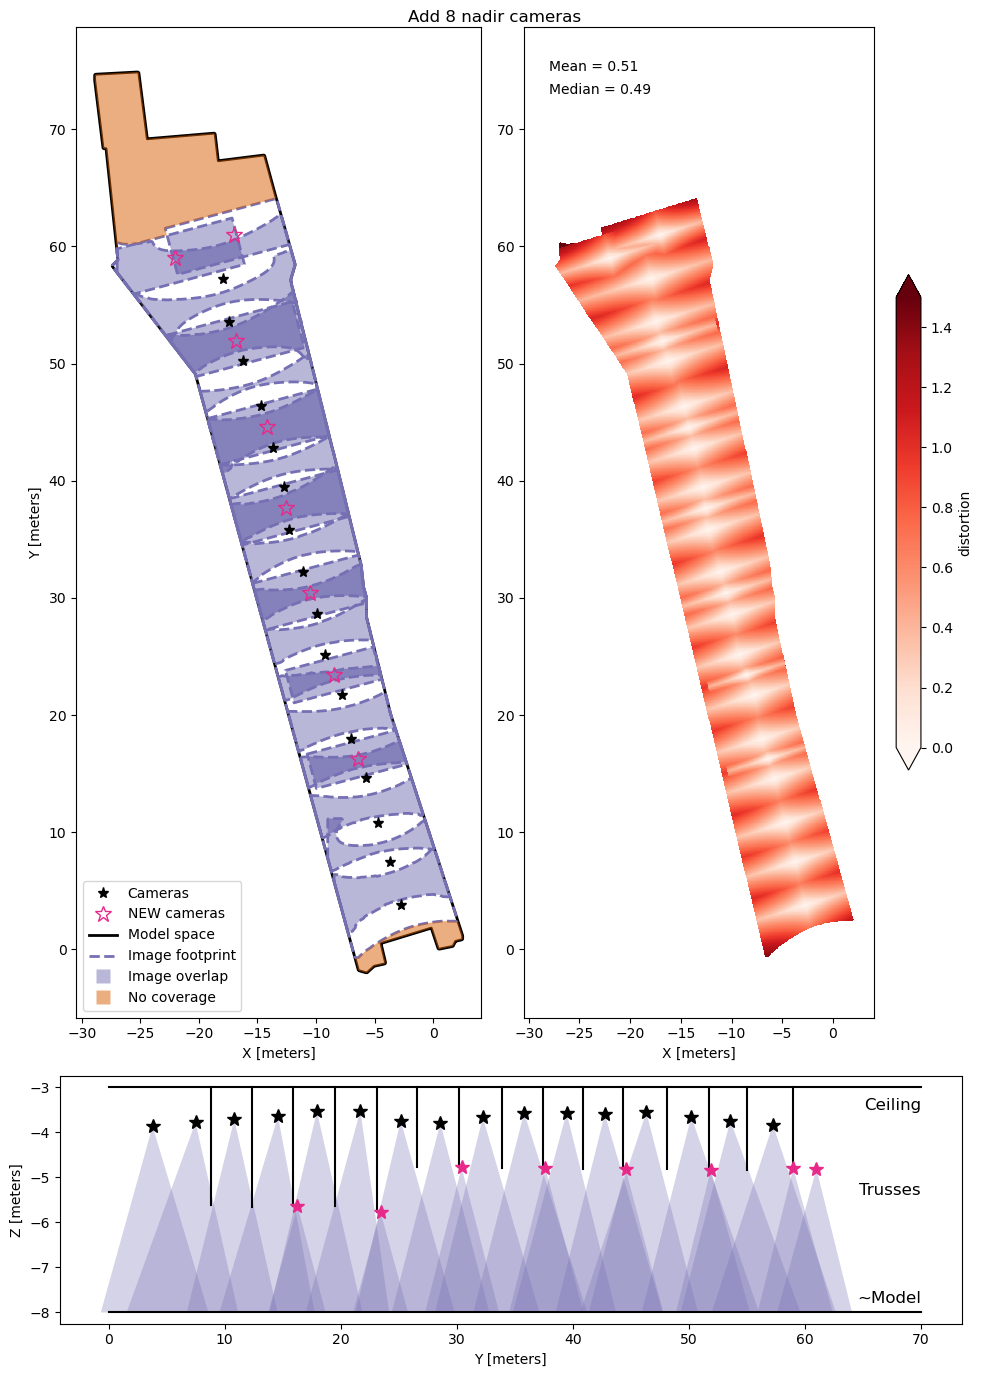

In [13]:
# 2 northern cameras
new_coords = np.array([
    (-22, 59, rh.loc[rh['Label']=='North 1', 'Z-Value - 15cm'].values[0]),
    (-17, 61, rh.loc[rh['Label']=='North 2', 'Z-Value - 15cm'].values[0])
])
# 6 others between
for ch1, ch2 in [
    ('ch04', 'ch05'), 
    ('ch06', 'ch07'), 
    ('ch08', 'ch09'),
    ('ch10', 'ch11'), 
    ('ch12', 'ch13'), 
    ('ch14', 'ch15')
    ]:
    X, Y = np.array(utils.get_coords_between_cams(ch1, ch2, cams))
    Z = rh.loc[rh['Label']==f'{ch1}-{ch2}', 'Z-Value - 15cm'].values[0]
    new_coords = np.append(new_coords, np.array([[X,Y,Z]]), axis=0)

(cams_new, cams_new_full, bounds_new_gdf, 
 bounds_new_full_gdf, overlap_new_gdf, 
 no_coverage_new_full) = utils.calculate_specs_from_new_coords(
     new_coords = new_coords,
     cams = cams,
     bounds = bounds_gdf,
     model_space = model_space_gdf,
     fov_h = fov_h,
     fov_v = fov_v,
     trusses_gdf = trusses_gdf
 )

# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]
# plot model coverage
utils.plot_model_coverage(ax[0], model_space_gdf, bounds_new_full_gdf, overlap_new_gdf, cams_new_full, no_coverage_new_full)

# plot vertical view
utils.plot_vertical_view(ax[2], trusses_gdf, cams, cams_new = cams_new, bounds = bounds_gdf, bounds_new = bounds_new_gdf)

# plot relative distortion
distortion_map = utils.create_distortion_map(
    cams_gdf = cams_new_full,
    footprints_gdf = bounds_new_full_gdf,
    yaw_series = 15 * np.ones(len(cams_new_full)),
    pitch_series = np.zeros(len(cams_new_full)),
    roll_series = np.zeros(len(cams_new_full)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf
)
# add the minimum value
distortion_map += 5.297444280721465
distortion_map.plot(ax=ax[1], cmap='Reds', vmin=0, vmax=1.5, cbar_kwargs={'shrink': 0.5})
# print distortion stats
ax[1].text(-28, 75, f"Mean = {np.round(distortion_map.mean().data, 2)}")
ax[1].text(-28, 73, f"Median = {np.round(distortion_map.median().data, 2)}")
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
ax[0].legend(loc='lower left')

fig.suptitle('Add 8 nadir cameras')
fig.tight_layout()
plt.show()

# # Save figure
# fig_file = os.path.join(output_folder, 'add_8_nadir_cameras.png')
# fig.savefig(fig_file, dpi=300, bbox_inches='tight')
# print('Figure saved to file:', fig_file)

# # Save new specs
# out_file = os.path.join(output_folder, 'add_8_nadir_cams_specs.csv')
# save_specs_los(bounds_new_gdf, cams_new, out_file, fov_h=fov_h, fov_v=fov_v)

## Add 8 cameras with 45 degree angles

/Users/rdcrlrka/.local/share/mamba/envs/soo_locks/lib/python3.12/site-packages/geopandas/array.py:1755: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 19N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


No coverage area =  125.6 m^2


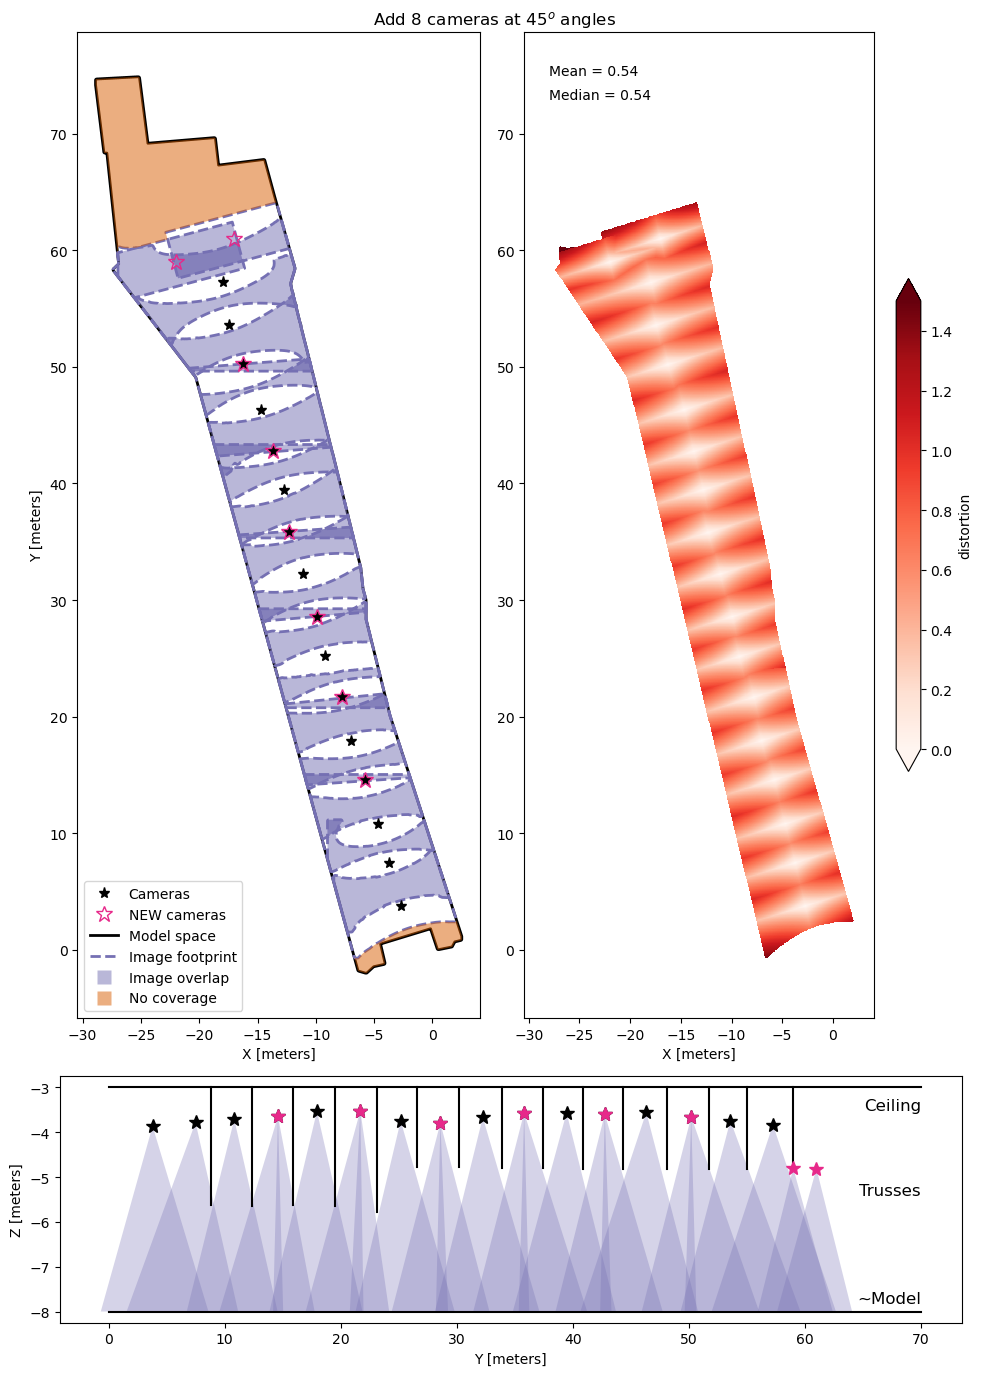

In [14]:
new_coords = np.array([
    (-22, 59, rh.loc[rh['Label']=='North 1', 'Z-Value - 15cm'].values[0]),
    (-17, 61, rh.loc[rh['Label']=='North 2', 'Z-Value - 15cm'].values[0]),
    cams.loc[cams['channel']=='ch04', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch06', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch08', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch10', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch12', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch14', ['X', 'Y', 'Z']].values[0],
])

new_rolls = np.concatenate([
    np.zeros(2),                            # northern-most cams
    45* np.array([-1, 1, -1, 1, -1, 1])     # rest of the cams
])

(cams_new, cams_new_full, bounds_new_gdf, 
 bounds_new_full_gdf, overlap_new_gdf, 
 no_coverage_new_full) = utils.calculate_specs_from_new_coords(
     new_coords = new_coords,
     new_rolls = new_rolls,
     cams = cams,
     bounds = bounds_gdf,
     model_space = model_space_gdf,
     fov_h = fov_h,
     fov_v = fov_v,
     trusses_gdf = trusses_gdf
 )

# Calculate map of relative distortion
distortion_map = utils.create_distortion_map(
    cams_gdf = cams_new_full,
    footprints_gdf = bounds_new_full_gdf,
    yaw_series = 15 * np.ones(len(cams_new_full)),
    roll_series = np.concatenate([np.zeros(len(cams)), new_rolls]), 
    pitch_series = np.zeros(len(cams_new_full)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf,
)
# add the minimum value
distortion_map += 5.297444280721465

# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]

utils.plot_model_coverage(ax[0], model_space_gdf, bounds_new_full_gdf, overlap_new_gdf, cams_new_full, no_coverage_new_full)

utils.plot_vertical_view(ax[2], trusses_gdf, cams, cams_new = cams_new, bounds = bounds_gdf, bounds_new = bounds_new_gdf)

distortion_map.plot(ax=ax[1], cmap='Reds', vmin=0, vmax=1.5, cbar_kwargs={'shrink': 0.5})

# print distortion stats
ax[1].text(-28, 75, f"Mean = {np.round(distortion_map.mean().data, 2)}")
ax[1].text(-28, 73, f"Median = {np.round(distortion_map.median().data, 2)}")
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
ax[0].legend(loc='lower left')

fig.suptitle('Add 8 cameras at 45$^o$ angles')
fig.tight_layout()
plt.show()

# # Save figure
# fig_file = os.path.join(output_folder, 'add_8_angled_cameras.png')
# fig.savefig(fig_file, dpi=300, bbox_inches='tight')
# print('Figure saved to file:', fig_file)

# # Save new specs
# out_file = os.path.join(output_folder, 'add_8_angled_cams_specs.csv')
# save_specs_los(bounds_new_gdf, cams_new, out_file, fov_h=fov_h, fov_v=fov_v)

## Add 16 more NADIR cameras at truss height

/Users/rdcrlrka/.local/share/mamba/envs/soo_locks/lib/python3.12/site-packages/geopandas/array.py:1755: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 19N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


No coverage area =  125.6 m^2


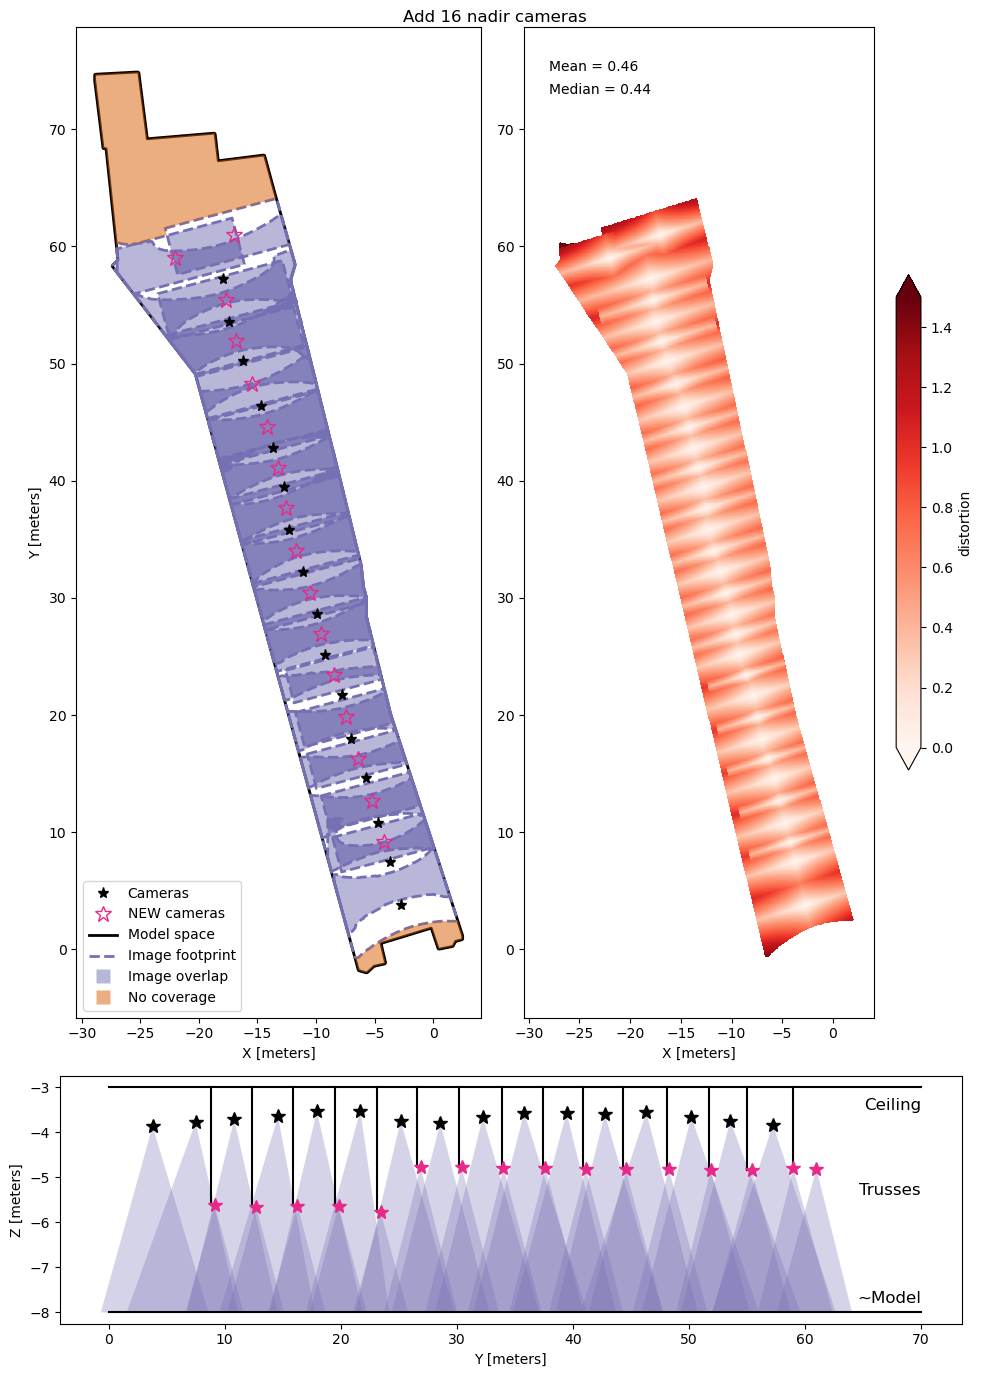

Figure saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_16_nadir_cameras.png
New camera specs saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_16_nadir_cams_specs.csv


In [16]:
# 2 northern cameras
new_coords = np.array([
    (-22, 59, rh.loc[rh['Label']=='North 1', 'Z-Value - 15cm'].values[0]),
    (-17, 61, rh.loc[rh['Label']=='North 2', 'Z-Value - 15cm'].values[0])
])
# 14 others between
for ch1, ch2 in [
    ('ch02', 'ch03'),
    ('ch03', 'ch04'),
    ('ch04', 'ch05'),
    ('ch05', 'ch06'),
    ('ch06', 'ch07'), 
    ('ch07', 'ch08'),
    ('ch08', 'ch09'),
    ('ch09', 'ch10'),
    ('ch10', 'ch11'), 
    ('ch11', 'ch12'),
    ('ch12', 'ch13'), 
    ('ch13', 'ch14'),
    ('ch14', 'ch15'),
    ('ch15', 'ch16')
    ]:
    X, Y = np.array(utils.get_coords_between_cams(ch1, ch2, cams))
    Z = rh.loc[rh['Label']==f'{ch1}-{ch2}', 'Z-Value - 15cm'].values[0]
    new_coords = np.append(new_coords, np.array([[X,Y,Z]]), axis=0)

(cams_new, cams_new_full, bounds_new_gdf, 
 bounds_new_full_gdf, overlap_new_gdf, 
 no_coverage_new_full) = utils.calculate_specs_from_new_coords(
     new_coords = new_coords,
     cams = cams,
     bounds = bounds_gdf,
     model_space = model_space_gdf,
     fov_h = fov_h,
     fov_v = fov_v,
     trusses_gdf = trusses_gdf
 )

# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]
# plot model coverage
utils.plot_model_coverage(ax[0], model_space_gdf, bounds_new_full_gdf, overlap_new_gdf, cams_new_full, no_coverage_new_full)

# plot vertical view
utils.plot_vertical_view(ax[2], trusses_gdf, cams, cams_new = cams_new, bounds = bounds_gdf, bounds_new = bounds_new_gdf)

# plot relative distortion
distortion_map = utils.create_distortion_map(
    cams_gdf = cams_new_full,
    footprints_gdf = bounds_new_full_gdf,
    yaw_series = 15 * np.ones(len(cams_new_full)),
    pitch_series = np.zeros(len(cams_new_full)),
    roll_series = np.zeros(len(cams_new_full)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf
)
# add the minimum value
distortion_map += 5.297444280721465
distortion_map.plot(ax=ax[1], cmap='Reds', vmin=0, vmax=1.5, cbar_kwargs={'shrink': 0.5})
# print distortion stats
ax[1].text(-28, 75, f"Mean = {np.round(distortion_map.mean().data, 2)}")
ax[1].text(-28, 73, f"Median = {np.round(distortion_map.median().data, 2)}")
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
ax[0].legend(loc='lower left')

fig.suptitle('Add 16 nadir cameras')
fig.tight_layout()
plt.show()

# Save figure
fig_file = os.path.join(output_folder, 'add_16_nadir_cameras.png')
fig.savefig(fig_file, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_file)

# Save new specs
out_file = os.path.join(output_folder, 'add_16_nadir_cams_specs.csv')
utils.save_specs_los(bounds_new_gdf, cams_new=cams_new, cams=cams, out_file=out_file, fov_h=fov_h, fov_v=fov_v)

## Add 16 more cameras at 45 degree angles

In [63]:
import importlib
importlib.reload(utils)

<module 'model_camera_coverage_utils' from '/Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/camera_calibration/model_camera_coverage_utils.py'>

0 0
0 -0.3825805469423777
0.6508755173526843 -0.607084029136093
0.8996858432356638 -0.44728340333144356
0.6952662163089727 -0.6508213914940982
0.9049545040965369 -0.5491567996981425
0.7282866841636881 -0.5467340808122038
0.6476451587517787 -0.6599122310029059
0.6267339668240022 -0.6630686966332888
0.4644987531813598 -0.670821279599899
0.526533444271237 -0.42934925197970114
0.38008908069302555 -0.5741384294677018
0.49821675461166137 -0.7853358504113785
0.5646210302903183 -0.4394591351432595
0.19533562089041104 -0.16777872636220065
0.3427560785448235 0
0 0
0 0
0 0
0.6508755173526843 0
0 -18.31956869663329
7.776975517352682 0
0 -18.2094492519797
14.998575517352686 0
0 -14.744938429467707
22.075675517352686 0
0 -17.947178726362196
29.296475517352683 0
0 -13.9618857511202
32.64668584323566 0
0 -6.509485751120202
29.147686684163684 0


/Users/rdcrlrka/.local/share/mamba/envs/soo_locks/lib/python3.12/site-packages/geopandas/array.py:1755: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 19N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


No coverage area =  45.6 m^2


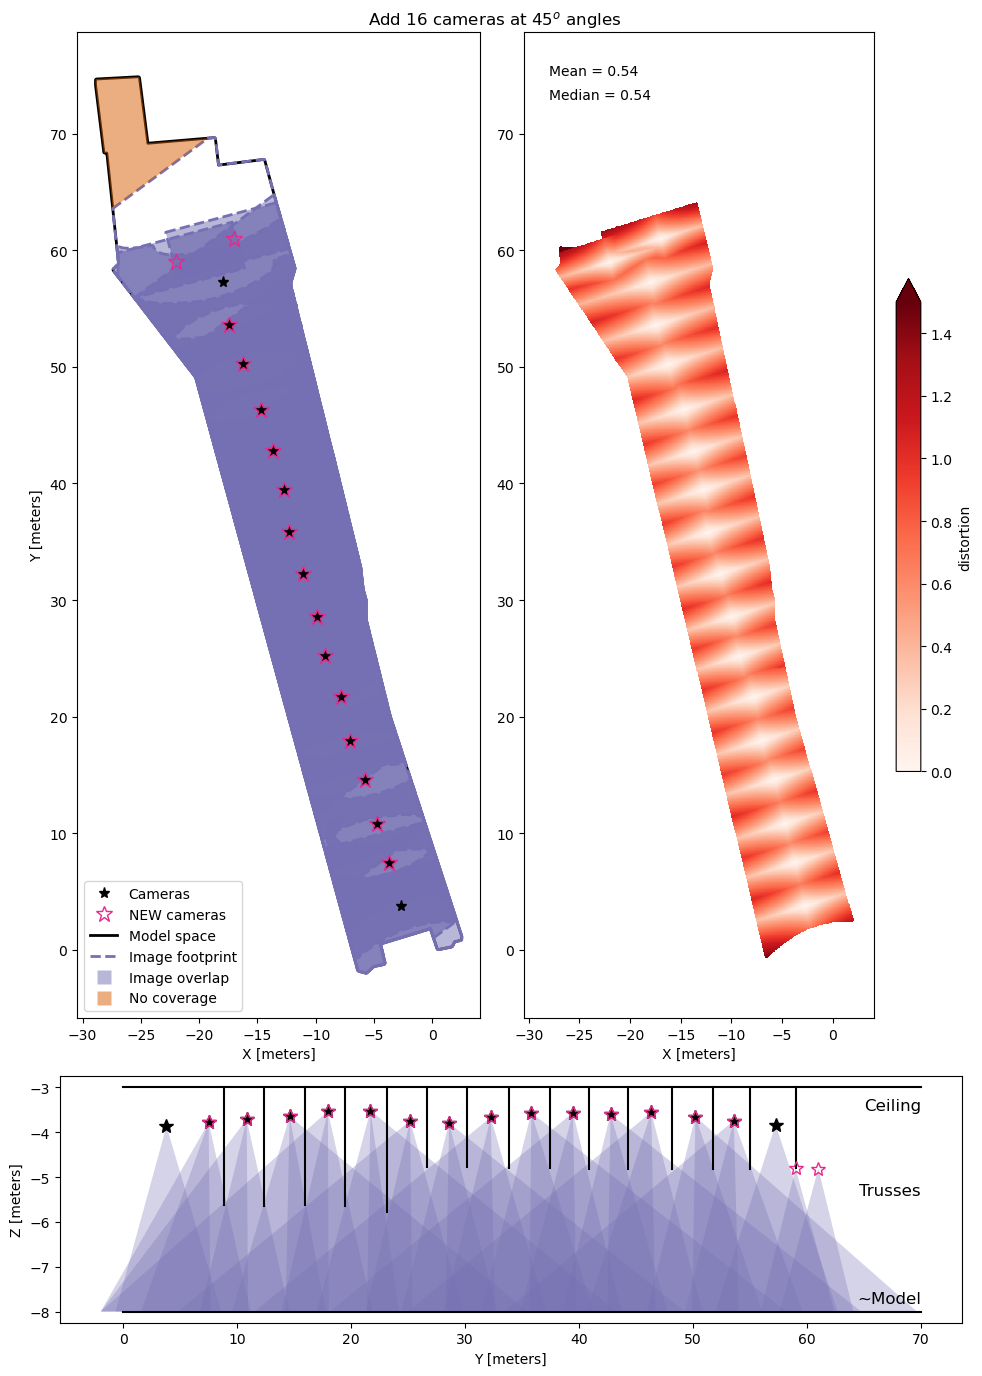

In [64]:
new_coords = np.array([
    (-22, 59, rh.loc[rh['Label']=='North 1', 'Z-Value - 15cm'].values[0]),
    (-17, 61, rh.loc[rh['Label']=='North 2', 'Z-Value - 15cm'].values[0]),
    cams.loc[cams['channel']=='ch02', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch03', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch04', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch05', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch06', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch07', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch08', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch09', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch10', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch11', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch12', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch13', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch14', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch15', ['X', 'Y', 'Z']].values[0],
])

new_rolls = np.concatenate([
    np.zeros(2),                            # northern-most cams
    45* np.array([1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1])     # rest of the cams
])

(cams_new, cams_new_full, bounds_new_gdf, 
 bounds_new_full_gdf, overlap_new_gdf, 
 no_coverage_new_full) = utils.calculate_specs_from_new_coords(
     new_coords = new_coords,
     new_rolls = new_rolls,
     cams = cams,
     bounds = bounds_gdf,
     model_space = model_space_gdf,
     fov_h = fov_h,
     fov_v = fov_v,
     trusses_gdf = trusses_gdf
 )

# Calculate map of relative distortion
distortion_map = utils.create_distortion_map(
    cams_gdf = cams_new_full,
    footprints_gdf = bounds_new_full_gdf,
    yaw_series = 15 * np.ones(len(cams_new_full)),
    roll_series = np.concatenate([np.zeros(len(cams)), new_rolls]), 
    pitch_series = np.zeros(len(cams_new_full)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf
)

# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]
# plot model coverage
utils.plot_model_coverage(ax[0], model_space_gdf, bounds_new_full_gdf, overlap_new_gdf, cams_new_full, no_coverage_new_full)

# plot vertical view
utils.plot_vertical_view(ax[2], trusses_gdf, cams, cams_new = cams_new, bounds = bounds_gdf, bounds_new = bounds_new_gdf)

# plot relative distortion
# add the minimum value
distortion_map += 5.297444280721465
distortion_map.plot(ax=ax[1], cmap='Reds', vmin=0, vmax=1.5, cbar_kwargs={'shrink': 0.5})
# print distortion stats
ax[1].text(-28, 75, f"Mean = {np.round(distortion_map.mean().data, 2)}")
ax[1].text(-28, 73, f"Median = {np.round(distortion_map.median().data, 2)}")
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
ax[0].legend(loc='lower left')

fig.suptitle('Add 16 cameras at 45$^o$ angles')
fig.tight_layout()
plt.show()

# # Save figure
# fig_file = os.path.join(output_folder, 'add_16_angled_cameras.png')
# fig.savefig(fig_file, dpi=300, bbox_inches='tight')
# print('Figure saved to file:', fig_file)

# # Save new specs
# out_file = os.path.join(output_folder, 'add_16_angled_cams_specs.csv')
# utils.save_specs_los(bounds_new_gdf, cams_new=cams_new, cams=cams, out_file=out_file, fov_h=fov_h, fov_v=fov_v)